
# **<center>Machine Learning and Finance </center>**


## <center> Programming Sessing 5 - Solution - </center>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://mlfbg.github.io/MachineLearningInFinance/">
    <img src="https://drive.google.com/uc?export=view&id=1gmxxmwCR1WXK0IYtNqvE4QXFleznWqQO" height="50"/>
    Course page</a>
</td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1OjRifPKpVqnT7ZFpfy0rNYaxWBDqpPUd?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />Run in Google Colab</a>
  </td>
</table>


---
# Presentation of the Programming Session:




In this programming session, we would like to implement the GloVe approach. It was introduced by Jeffrey Pennington, Richard Socher and  Christopher D. Manning in the paper: [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)

The programming session is subdivided into three parts:

* In section 1, the objective is to load the data, preprocess it and create the **co-occurence matrix**. 
* In section 2, the objective is to train the model by using two different methods: **Gradient Descent** and **Alternating Least Squares**. 
* In section 3, the objective is to add a penalty term to the loss function as a **regularization** technique. 

**Notations:**

* $\mathcal{M}_{n,p}(\mathbb{R})$ is the space of the matrices composed of n rows and p columns.

* $I_n \in \mathcal{M}_{n,n}(\mathbb{R})$ is the identity matrix of size n.

* For all $z \in \mathbb{R}^D$, the $\mathcal{L}^2$ norm on $\mathbb{R}^D$ of $z$ is defined as follows: $||z||_2^2 = z^T z$

*  For all $A = [a_{ij}]_{i,j} \in \mathcal{M}_{n,p}(\mathbb{R})$ we define the Frobenius norm of $A$ as follows: $||A||_{\text{F}}^2 = \sum\limits_{i=1}^n \sum\limits_{j=1}^p a_{ij}^2$ 

* The gradient of a function $f : \theta \in \mathbb{R}^D \mapsto \mathbb{R}$ at $\theta\in \mathbb{R}^D$ is denoted as follows $\nabla_{\theta}f(\theta) = \left(\frac{\partial f}{\partial \theta_1}(\theta), \dots, \frac{\partial f}{\partial \theta_D}(\theta) \right)$

**Convention:** 
	
* The rows $(A_i)_{1 \leq i \leq n }$ of a matrix $A = \begin{pmatrix}
- & A_1 & - \\
\vdots & \vdots & \vdots \\
- & A_n & - 
\end{pmatrix}\in \mathcal{M}_{n,p}(\mathbb{R}) $ are 				considered $\mathcal{M}_{p,1}(\mathbb{R})$ matrices. 

* The columns $(B_j)_{1 \leq j \leq p }$ of a matrix $B = \begin{pmatrix}
| & \dots & | \\
B_1 & \dots & B_p \\
| & \dots & | 
\end{pmatrix}\in \mathcal{M}_{n,p}(\mathbb{R}) $ are considered $\mathcal{M}_{n,1}(\mathbb{R})$ matrices. 




---


In [ ]:
# Access files from Google Drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os 
os.chdir('./gdrive/My Drive/Teaching/Imperial_College/Colab Notebooks/Programming_Session_5/')

In [ ]:
# Import basic libraries
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plots 
from tensorflow.keras.preprocessing.text import Tokenizer # for processing text
import random # to shuffle the sequences
import os 
plt.style.use('dark_background') # to adapt the colors to a dark background
from IPython.display import Image # for showing graphs from the lectures

In [ ]:
# Hyperparameters
MAX_VOCAB = 999
C = 10 # Context size
V = MAX_VOCAB + 1 # Vocabulary size
EPOCHS = 64
D = 100 # Embedding dimension

# 1. Getting the statistics of the word occurences 

## 1.1 Introducing the problem

The objective of the programming session is to train a model on a corpus of training sentences in order to represent words in a $D$-dimensional space. We would like to encode the similarity between the words in the embedding vectors themselves. 


---
<font color=green>Q1:</font>
<br><font color='green'>
Explain why this notion of similarity is not encoded in the one hot vector representation of words.
</font>

---

---
**Solution**:

Like explained in Slide 7 of [Lecture 5](https://hm-ai.github.io/MLF/Lectures/Lecture_5.pdf), any two V-dimensional one hot vectors will be orthogonal according to the dot product similarty measure.

---

Several methods have been used to create word embeddings. The most popular ones rely on the intuition that *a word's meaning is given by the words that frequently appear close-by*. 

For instance, [the word2vec approach](https://arxiv.org/pdf/1301.3781.pdf) represents the tokens as parameters of a shallow neural network predicting a word's context given the world itself. 

Although the shallow window-based model captures linguistic patterns between word vectors and performs well on the word analogy task ($w_{\text{France}} - w_{\text{Paris}} \approx w_{\text{England}} - w_{\text{London}}$), the model suffers from the disadvantage that they do not operate directly and the co-occurence statistics.

The GloVe method is a popular method used to learn low-dimensional word representations by using **matrix factorization** methods on a matrix of word-word **co-occurence** statistics. 

## 1.2 Preprocessing the data

The **data** folder contains a csv file named `RedditNews.csv` (Source: Sun, J. (2016, August) Daily News for Stock Market Prediction, Version 1. Retrieved [26 may 2020]).

In the `RedditNews.csv` file are stored historical news headlines from Reddit WorldNews Channel, ranked by reddit users' votes, and only the top 25 headlines are considered for a single date.

You will find two colomns: 


* The first column is for the "date".
* The second column is for the "News". As all the news are ranked from top to bottom, there are only 25 lines for each date.  

---
<font color=green>Q2:</font>
<br><font color='green'>
Load the data from the csv file, create a list of all the news.
</font>

---

In [ ]:
# Import the data
data = pd.read_csv("data/RedditNews.csv")
# Select the news
news = data["News"].values

In [ ]:
data

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
...,...,...
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."




---
<font color=green>Q3:</font>
<br><font color='green'>
Preprocess the data by transforming the list of sentences into a list of sequences of integers called `news_processed` , via a dictionary that maps the words to integers. 
</font>

---




<center><img width="400" src = "https://drive.google.com/uc?export=view&id=15_ocFu9iG0sOPmK0dKhECzTUbIXFSeHC"></center>

In [ ]:
# Preprocessing 
tokenizer = Tokenizer(num_words = MAX_VOCAB,
                      oov_token='UNK',
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                      lower=True)
# Create the word_index dictionary
tokenizer.fit_on_texts(news)
# Transforming news into a list of lists of integers
news_processed = tokenizer.texts_to_sequences(news)

---
<font color=green>Q4:</font>
<br><font color='green'>
For each sentence, add a specific index for the token "$<\text{sos}>$" (start of sequence) at the beginning of each sequence and an index for the token "$<\text{eos}>$" (end of sequence) at the end of each sequence. The resulting list of lists of integers is called `sequences`. 
</font>

---

In [ ]:
# Introduce the tokens "<sos>" and "<eos>":
word_index = {}
word_index['<sos>'] = 0
for k, v in tokenizer.word_index.items():
    if v < MAX_VOCAB:
        word_index[k] = v
word_index['<eos>'] = MAX_VOCAB

# Shuffle the sentences
random.shuffle(news_processed)

# add the indices of <sos> and <eos>
sequences = []
for sequence in news_processed:
    sequences.append([0] + sequence + [MAX_VOCAB])

## 1.3 Creating the co-occurence matrix

Let $V$ be the vocabulary size of the training corpus. 

In [Lecture 5](https://hm-ai.github.io/MLF/Lectures/Lecture_5.pdf), we have defined the co-occurence matrix $X = [X_{ij}]_{i,j} \in \mathcal{M}_{V,V}(\mathbb{R})$, whose entries $X_{ij}$ represent the number of times word $j$ appears in the context of word $i$. 

Algorithm 1 summarizes the steps involved in estimating the co-occurence matrix from the corpus `sequences`.

<center><img width="400" src = "https://drive.google.com/uc?export=view&id=186c4b_X8mDEgBoVNZKEw7sfXOzKa-KN-"></center>


In Algorithm 1, each time a word $w[j]$ (of index $j$ in sequence) appears in the context of a center word $w[i]$ (of index $i$ in sequence), we increase the value of $X[w[i], w[j]]$ by a value of $1$ regardless of how close the word $w[j]$ is to the word $w[i]$. 

We would like to take into consideration the distance $d(i,j)$ between the center word $w[i]$ and the context word $w[j]$ when updating the value $X[w[i], w[j]]$, as shown the following figure:

<center><img width="600" src = "https://drive.google.com/uc?export=view&id=1m1_32ovMfjkRVb-B_3gPizDI1QUfZjQ4"></center>

---
<font color=green>Q5:</font>
<br><font color='green'>
Explain why it makes more sense to use the following update equation for $X[w[i], w[j]]$ when word $w[j]$ of index $j$ is in the context word $w[i]$ of index $i$. 
 
\begin{equation*}
X[w[i], w[j]] \longleftarrow X[w[i], w[j]] + \frac{1}{|i-j|}
\end{equation*}
</font>

---

---
**Solution**

* By using the update: $X[w[i], w[j]] \longleftarrow X[w[i], w[j]] + 1$ we make the assumption that all the words $w[j]$ are equally important as context vectors of center word $w[i]$

* By using the update: $X[w[i], w[j]] \longleftarrow X[w[i], w[j]] + \frac{1}{|i-j|}$, we would like to give more weight to closer context words because they are more related to the center word. 

* Another benefit from the update $X[w[i], w[j]] \longleftarrow X[w[i], w[j]] + \frac{1}{|i-j|}$ is to reduce the impact of the `context_size` hyperparameter. 

---

---
<font color=green>Q6:</font>
<br><font color='green'>
Implement Algorithm 2 to get the co-occurence matrix $X$ using a function called `get_cooccurence_matrix()`.

The function takes as arguments `sequences`, `context_size` and `vocabulary_size` and outputs the matrix `X`.
</font>

---


<center><img width="400" src = "https://drive.google.com/uc?export=view&id=1Xt6SXVNxlsPHqIWk1IIaLOZcpTrQWZSd"></center>



In [ ]:
def get_occurence_matrix(sentences, context_size, vocabulary_size):
  """
  This functions aims at creating the co-occurence matrix from the corpus
  composed of sentences
  """
  X = np.zeros((vocabulary_size, vocabulary_size))
  N = len(sentences)
  print("number of sentences to process:", N)
  it = 0
  for sentence in sentences:
      it += 1
      if it % 10000 == 0:
          print("processed", it, "/", N)
      n = len(sentence)
      for i in range(n):
          # center word
          w_i = sentence[i]

          start = max(0, i - context_size)
          end = min(n-1, i + context_size)

          # we can either choose only one side as context, or both
          # here we are doing both
          
          # left context side
          for j in range(start, i):
              # context word
              w_j = sentence[j]
              # inverse of distance between w_i and w_j
              inverse_distance = 1. / (i-j)
              # Add the inverse of the distance to X[w_i, w_j]
              X[w_i, w_j] += inverse_distance
          
          # right context side
          for j in range(i+1, end+1):
              # context word
              w_j = sentence[j]
              # inverse of distance between w_i and w_j
              inverse_distance = 1. / (j-i)
              # Add the inverse of the distance to X[w_i, w_j]
              X[w_i, w_j] += inverse_distance    
  return X

In [ ]:
print("Get the co-occurence matrix X...")
X = get_occurence_matrix(sequences, C, V)
print("The shape of X is", X.shape)

Get the co-occurence matrix X...
number of sentences to process: 73608
processed 10000 / 73608
processed 20000 / 73608
processed 30000 / 73608
processed 40000 / 73608
processed 50000 / 73608
processed 60000 / 73608
processed 70000 / 73608
The shape of X is (1000, 1000)




Since non-zero values in the matrix $X$ are very large, we apply the logarithm function to all the elements of $X$ (after adding 1 to all the entries $X_{ij}$ to avoid applying the logarithm on zero values). The resulting matrix is still a sparse matrix. We will denote it $\log X$.  



---
<font color=green>Q7:</font>
<br><font color='green'>
Create the matrix $\log X$, call it `logX`.
</font>

---

In [ ]:
print("Get logX...")
logX = np.log(X+1)
print("The shape of logX is", logX.shape)

Get logX...
The shape of logX is (1000, 1000)


# 2. Training the weighted least squares regression model

## 2.1 Introducing the cost function

The logarithm of the co-occurence matrix $\log X$ has been defined in the previous section. The objective of this section is to approximate $\log X$ using a factorization method as follows:

\begin{equation*}
	\forall (i,j) \in \{1, \dots, V \}^2 \quad \log X_{ij} \approx W_i^T \tilde{W}_j + b_i + \tilde{b}_j
\end{equation*}


The parameters of the regression model are:


* A first **embedding matrix** and a bias term associated with it:
	\begin{equation*}
W = \begin{pmatrix}
- & W_1 & - \\
\vdots & \vdots & \vdots \\
- & W_V & - 
\end{pmatrix}\in \mathcal{M}_{V, D}(\mathbb{R}), 	\quad  	b = \begin{pmatrix}
 b_1  \\
 \vdots  \\
 b_V  
\end{pmatrix}\in \mathbb{R}^{V}
	\end{equation*}		
	

* A second **embedding matrix** and a bias term associated with it:
	\begin{equation*}
\tilde{W} = \begin{pmatrix}
- & \tilde{W}_1 & - \\
\vdots & \vdots & \vdots \\
- & \tilde{W}_V & - 
\end{pmatrix}\in \mathcal{M}_{V, D}(\mathbb{R}), \quad \tilde{b} = \begin{pmatrix}
 \tilde{b}_1  \\
 \vdots  \\
 \tilde{b}_V  
\end{pmatrix}\in \mathbb{R}^{V} 	
	\end{equation*}	


Instead of equal-weighting all the co-occurences, we introduce a **weighting function** $f(X_{ij})$ defined as follows: 

\begin{equation*}
\forall x \in \mathbb{R}_{+} \quad f(x) =  \begin{cases}
      (x/x_{\text{max}})^{\alpha} & \text{if   $x < x_{\text{max}}$}\\
      1 & \text{otherwise}
          \end{cases}  
\end{equation*}


The function $f$ is represented in the following figure with $x_{\text{max}}=100$ and $\alpha=0.75$

<center><img width="400" src = "https://drive.google.com/uc?export=view&id=1D7muXkREj-5pPVUWyAfe8qrwYeIe0XzN"></center>




---
<font color=green>Q8:</font>
<br><font color='green'>
Create a matrix of shape $(V, V)$ whose entries are $f(X_{ij})$. 
Let's call it `fX`. Use the hyperparameters $x_{\text{max}}=100$ and $\alpha=0.75$
</font>

---

In [ ]:
print("Get f(X)...")
xmax = 100
alpha = 0.75
fX = np.zeros((V, V))
fX[X < xmax] = (X[X < xmax] / float(xmax)) ** alpha
fX[X >= xmax] = 1
print("The shape of fX is", fX.shape)

Get f(X)...
The shape of fX is (1000, 1000)


---
<font color=green>Q9:</font>
<br><font color='green'>
What are the hyperparameters associated with the weighting function and what is the intuition behind introducing it?
</font>

---

---
**Solution:**
* There are two hyperparameters associated with the weighting function: $x_{\text{max}}$ and $\alpha$

* By introducing the weighting function, we make the assumption that rare occurences are noisy and carry less information than the more frequent ones. Therefore, when the entry $X_{ij}$ is small, we would like to reduce the contribution of the loss term associated with it (i.e, $(\log X_{ij} - W_i^T \tilde{W}_j - b_i - \tilde{b}_j)^2$) to the global loss. 

---

The **cost function** can then be written as follows: 

\begin{equation*}
J = \sum_{i=1}^V \sum_{j=1}^V f(X_{ij}) (\log X_{ij} - W_i^T \tilde{W}_j - b_i - \tilde{b}_j)^2
\end{equation*}


The gradients of the cost function $J$ with respect to all the parameters are introduced in the following equations:


For all $i \in \{1, \dots, V \}$ and all $j \in \{ 1, \dots, V \}$:


\begin{align} 
& \nabla_{W_i} J(W_i) = -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} \quad \text{(2.1)} \\
& \nabla_{\tilde{W}_j} J(W_j) = -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) W_{i'} \quad \text{(2.2)}  \\
&\nabla_{b_i} J(b_i) = -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) \quad \text{(2.3)}  \\
& \nabla_{\tilde{b}_j} J(\tilde{b}_j) = -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) \quad \text{(2.4)} 
\end{align}



---
<font color=green>Q10:</font>
<br><font color='green'>
What is the total number of parameters in the model ? What are the shapes of all the gradients introduced in the equations (2.1), (2.2), (2.3) and (2.4) ?
</font>

---

---
**Solution:**

* Number of parameters:
  * The matrices $W$ and $\tilde{W}$ are both in $\mathcal{M}_{V, D}(\mathbb{R})$.
  * The vectors $b$ and $\tilde{b}$ are both $V$-dimensional vectors.
  * So the total number of parameters $N_{\text{parameters}}$ is 

  \begin{equation}
    N_{\text{parameters}} = 2 (V D) + 2 V
  \end{equation}

* Shapes of gradients:

  * For all $i \in \{1, \dots, V \}$ and for all $j \in \{1, \dots, V \}$:

\begin{align} 
& \nabla_{W_i} J(W_i) \in \mathcal{M}_{D, 1}(\mathbb{R}) \\
& \nabla_{\tilde{W}_j} J(W_j) \in \mathcal{M}_{D, 1}(\mathbb{R})  \\
&\nabla_{b_i} J(b_i)  \in \mathbb{R}  \\
& \nabla_{\tilde{b}_j} J(\tilde{b}_j) \in \mathbb{R}
\end{align}
    

---

Let us introduce two training methods:

* The first training method is called **alternating least squares**. It consists in finding the update equations by setting all the gradients to zero.
* The second training method consists in applying the **gradient descent** algorithm.


## 2.2 Alternating least squares

We would like to estimate the parameters $W, \tilde{W}, b, \tilde{b}$ by setting the gradients to zero. 






By setting the gradients to zero, we get the following update equations: 

\begin{align*}
&\nabla_{W_i} J(W_i) = 0 \iff W_i = \left( \sum_{j'=1}^V f(X_{ij'}) \tilde{W}_{j'} \tilde{W}_{j'}^T \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - b_i - \tilde{b}_{j'}) \tilde{W}_{j'} \right)  \\
&\nabla_{\tilde{W}_j} J(\tilde{W}_j) = 0 \iff \tilde{W}_j = \left( \sum_{i'=1}^V f(X_{i' j}) W_{i'} W_{i'}^T \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - b_{i'} - \tilde{b}_{j}) W_{i'} \right)  \\
&\nabla_{b_i} J(b_i) = 0 \iff b_i = \left( \sum_{j'=1}^V f(X_{ij'})  \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - W_i^T \tilde{W}_{j'} - \tilde{b}_{j'}) \right)  \\
&\nabla_{\tilde{b}_j} J(\tilde{b}_j) = 0 \iff \tilde{b}_j = \left( \sum_{i'=1}^V f(X_{i' j})  \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - W_{i'}^T \tilde{W}_{j} - b_{i'}) \right) 
\end{align*}


The proof can be found in **appendix A**

Each update equation for one parameter is a function of the other parameters. Therefore, in order to train our model, we can choose a number of iterations $N_{\text{epochs}}$, and apply the update equations $N_{\text{epochs}}$ times by keeping track of the loss to make sure it converges. 

For each iteration step $t \in \{0, \dots, N_{\text{epochs}}-1 \}$, let $W^{(t)}, \tilde{W}^{(t)}, b^{(t)}, \tilde{b}^{(t)}$ represent the parameters of our model at the iteration $t$. 


The update equations from iteration $t$ to $t+1$ can then be written as follows:

\begin{align}
&W_i^{(t+1)} \longleftarrow \left( \sum_{j'=1}^V f(X_{ij'}) \tilde{W}_{j'}^{(t)} \tilde{W}_{j'}^{(t)^T} \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - b_i^{(t)} - \tilde{b}_{j'}^{(t)}) \tilde{W}_{j'}^{(t)} \right) \quad \text{(2.5)} \\
&\tilde{W}_j^{(t+1)} \longleftarrow \left( \sum_{i'=1}^V f(X_{i' j}) W_{i'}^{(t)} W_{i'}^{(t)^T} \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - b_{i'}^{(t)} - \tilde{b}_{j}^{(t)}) W_{i'}^{(t)} \right) \quad \text{(2.6)}  \\
&b_i^{(t+1)} \longleftarrow \left( \sum_{j'=1}^V f(X_{ij'})  \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - W_i^{(t)^T} \tilde{W}_{j'}^{(t)} - \tilde{b}_{j'}^{(t)}) \right) \quad \text{(2.7)} \\
&\tilde{b}_j^{(t+1)} \longleftarrow \left( \sum_{i'=1}^V f(X_{i' j})  \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - W_{i'}^{(t)^T} \tilde{W}_{j}^{(t)} - b_{i'}^{(t)}) \right) \quad \text{(2.8)}
\end{align}



The pseudo code for the training algorithm can be expressed as follows: 


<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1DQmP3N13RH2hAP2-Szgk8TPhzcHICwGU"></center>




---
<font color=green>Q11:</font>
<br><font color='green'>
Implement the alternating least squares training algorithm
</font>

---

In [ ]:
# Optimization Hyperparameters
learning_rate=1e-4   
epochs = EPOCHS

# initialize weights
W = np.random.randn(V, D) / np.sqrt(V + D)
b = np.zeros(V)
W_tilde = np.random.randn(V, D) / np.sqrt(V + D)
b_tilde = np.zeros(V)



costs = []
for epoch in range(epochs):
    # epsilon (V, V) matrix such that epsilon_{ij} = logX_{ij} - W_i^T W_tilde_j - b_i - b_tilde_j
    epsilon = logX - W.dot(W_tilde.T) - b.reshape(V, 1) - b_tilde.reshape(1, V)
    # cost function sum_{ij} fX_{ij} (logX_{ij} - W_i^T W_tilde_j - b_i - b_tilde_j)^2 = sum_{ij} fX_{ij} epsilon_{ij}^2
    cost = (fX * epsilon * epsilon).sum()
    costs.append(cost)
    print("epoch: {}...cost: {}".format(epoch, cost))
    
    # update W
    print("Update W..")
    for i in range(V):
        if i%1000==0:
            print("Epoch {}... W is updated for {} words out of {}".format(epoch, i, V))
        # A = sum_{j'} fX_{ij'} W_tilde_j'  W_tilde_j'^T    
        A = (fX[i,:][None, :]*W_tilde.T).dot(W_tilde) # or A = (W_tilde.T).dot(W_tilde*(fX[i, :][:, None]))
        # B = sum_{j'} fX_{ij'} (logX_{ij'} - b_i - b_tilde_j') W_tilde_j'  
        B = (fX[i, :]*(logX[i, :] - b[i] - b_tilde)).dot(W_tilde)
        # W_i = A^{-1} B
        W[i] = np.linalg.solve(A, B)


    # update b
    print("Update b..")
    for i in range(V):
        if i%1000==0:
            print("Epoch {}... b is updated for {} words out of {}".format(epoch, i, V))
        # A = sum_{j'} fX_{ij'}  
        A = fX[i, :].sum()
        # B = sum_{j'} fX_{ij'} (logX_{ij'} - W_i^T W_tilde_j' - b_tilde_j') 
        B = fX[i, :].dot(logX[i, :] - W[i].dot(W_tilde.T) - b_tilde)
        # b_i = A^{-1} B
        b[i] = B/A

    # update W_tilde
    print("Update W_tilde..")
    for j in range(V):
        if j%1000==0:
            print("Epoch {}... W_tilde is updated for {} words out of {}".format(epoch, j, V))
        # A = sum_{i'} fX_{i'j} W_i'  W_i'^T    
        A = (fX[:, j][None, :]*(W.T)).dot(W)
        # B = sum_{i'} fX_{i'j} (logX_{i'j} - b_i' - b_tilde_j) W_i' 
        B = (fX[:, j]*(logX[:, j] - b - b_tilde[j])).dot(W)
        # W_tilde_j = A^{-1} B
        W_tilde[j] = np.linalg.solve(A, B)                
        
        
    # update b_tilde
    print("Update b_tilde..")
    for j in range(V):
        if j%1000==0:
            print("Epoch {}... b_tilde is updated for {} words out of {}".format(epoch, j, V))
        # A = sum_{i'} fX_{i'j}  
        A = fX[:, j].sum()
        # B = sum_{i'} fX_{i'j} (logX_{i'j} - W_i'^T W_tilde_j - b_i') 
        B = fX[:, j].dot(logX[:, j] - W.dot(W_tilde[j]) - b)
        # b_tilde_j = A^{-1} B
        b_tilde[j] = B/A


 

epoch: 0...cost: 436186.49119308114
Update W..
Epoch 0... W is updated for 0 words out of 1000
Update b..
Epoch 0... b is updated for 0 words out of 1000
Update W_tilde..
Epoch 0... W_tilde is updated for 0 words out of 1000
Update b_tilde..
Epoch 0... b_tilde is updated for 0 words out of 1000
epoch: 1...cost: 5038.988345826602
Update W..
Epoch 1... W is updated for 0 words out of 1000
Update b..
Epoch 1... b is updated for 0 words out of 1000
Update W_tilde..
Epoch 1... W_tilde is updated for 0 words out of 1000
Update b_tilde..
Epoch 1... b_tilde is updated for 0 words out of 1000
epoch: 2...cost: 2789.235340425804
Update W..
Epoch 2... W is updated for 0 words out of 1000
Update b..
Epoch 2... b is updated for 0 words out of 1000
Update W_tilde..
Epoch 2... W_tilde is updated for 0 words out of 1000
Update b_tilde..
Epoch 2... b_tilde is updated for 0 words out of 1000
epoch: 3...cost: 2470.9653432880596
Update W..
Epoch 3... W is updated for 0 words out of 1000
Update b..
Epoch 3.

---
<font color=green>Q12:</font>
<br><font color='green'>
 Plot the list of losses at the end of each iteration in Algorithm 3.
</font>

---

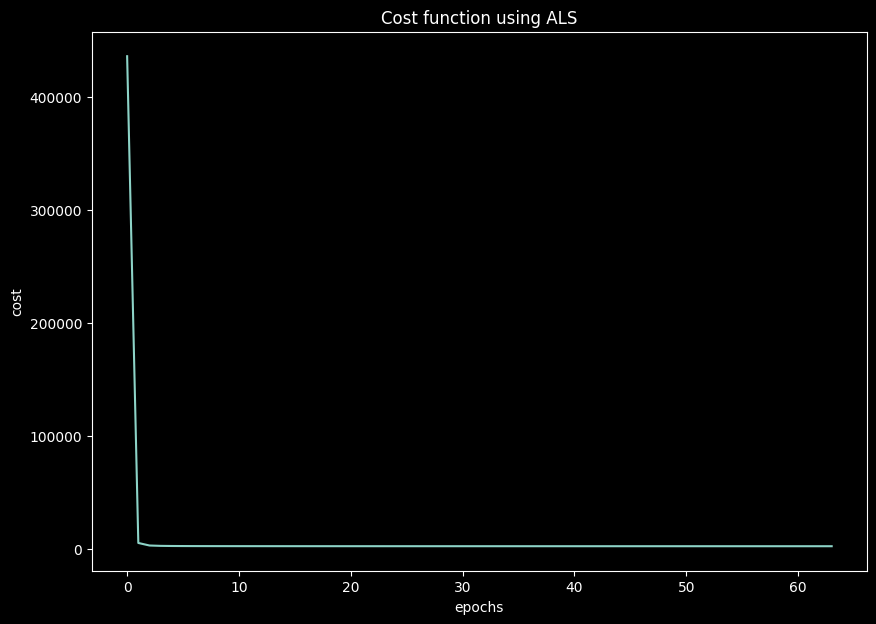

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(costs)
plt.xlabel("epochs")
plt.ylabel("cost")
plt.title("Cost function using ALS")
plt.show()

## 2.3 Learning the weights using gradient descent

In this section, we would like to estimate the parameters of the model using gradient descent.

Let $N_{\text{epochs}}$ be the number of epochs and $\eta$ be the learning rate. 
We get the following training algorithm:


<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1Od3xCvMWKOBhMpccmKOtoY3aT3UTJB5Z"></center>




---
<font color=green>Q13:</font>
<br><font color='green'>
Implement the gradient descent training algorithm (Algorithm 4).
</font>

---

In [ ]:
# initialize weights
W = np.random.randn(V, D) / np.sqrt(V + D)
b = np.zeros(V)
W_tilde = np.random.randn(V,D) / np.sqrt(V + D)
b_tilde = np.zeros(V)


costs = []
for epoch in range(epochs):
    # epsilon (V, V) matrix such that epsilon_{ij} = logX_{ij} - W_i^T W_tilde_j - b_i - b_tilde_j
    epsilon = logX - W.dot(W_tilde.T) - b.reshape(V, 1) - b_tilde.reshape(1, V)
    # cost function sum_{ij} fX_{ij} (logX_{ij} - W_i^T W_tilde_j - b_i - b_tilde_j)^2 = sum_{ij} fX_{ij} epsilon_{ij}^2
    cost = (fX * epsilon * epsilon).sum()
    costs.append(cost)
    print("epoch: {}...cost: {}".format(epoch, cost))

    # Update W
    print("Update W..")
    for i in range(V):
        if i%1000==0:
            print("Epoch {}... W is updated for {} words out of {}".format(epoch, i, V))
        # W_i -= learning_rate*(-2*sum_{j'} fX_{i,j'}*epsilon_{i,j'}*W_tilde_j')
        W[i] -= -2*learning_rate*(fX[i,:]*epsilon[i,:]).dot(W_tilde)


    # update b
    for i in range(V):
        if i%1000==0:
            print("Epoch {}... b is updated for {} words out of {}".format(epoch, i, V))
        # b_i -= learning_rate*(-2*sum_{j'} fX_{i,j'}*epsilon_{i,j'}
        b[i] -= -2*learning_rate*fX[i,:].dot(epsilon[i,:])


    # update W_tilde
    print("Update W_tilde..")
    for j in range(V):
        if j%1000==0:
            print("Epoch {}... W_tilde is updated for {} words out of {}".format(epoch, j, V))
        # W_tilde_j -= learning_rate*(-2*sum_{i'} fX_{i',j}*epsilon_{i',j}*W_i')
        W_tilde[j] -= -2*learning_rate*(fX[:,j]*epsilon[:,j]).dot(W)


    # update b_tilde
    print("Update b_tilde..")
    for j in range(V):
        if j%1000==0:
            print("Epoch {}... b_tilde is updated for {} words out of {}".format(epoch, j, V))
        # b_tilde_j -= learning_rate*(-2*sum_{i'} fX_{i',j}*epsilon_{i',j})
        b_tilde[j] -= -2*learning_rate*fX[:,j].dot(epsilon[:,j])

epoch: 0...cost: 436199.0745952835
Update W..
Epoch 0... W is updated for 0 words out of 1000
Epoch 0... b is updated for 0 words out of 1000
Update W_tilde..
Epoch 0... W_tilde is updated for 0 words out of 1000
Update b_tilde..
Epoch 0... b_tilde is updated for 0 words out of 1000
epoch: 1...cost: 344879.48189436167
Update W..
Epoch 1... W is updated for 0 words out of 1000
Epoch 1... b is updated for 0 words out of 1000
Update W_tilde..
Epoch 1... W_tilde is updated for 0 words out of 1000
Update b_tilde..
Epoch 1... b_tilde is updated for 0 words out of 1000
epoch: 2...cost: 278229.9505702876
Update W..
Epoch 2... W is updated for 0 words out of 1000
Epoch 2... b is updated for 0 words out of 1000
Update W_tilde..
Epoch 2... W_tilde is updated for 0 words out of 1000
Update b_tilde..
Epoch 2... b_tilde is updated for 0 words out of 1000
epoch: 3...cost: 228949.25595840148
Update W..
Epoch 3... W is updated for 0 words out of 1000
Epoch 3... b is updated for 0 words out of 1000
Upda

---
<font color=green>Q14:</font>
<br><font color='green'>
 Plot the list of losses at the end of each iteration in Algorithm 4.
</font>

---

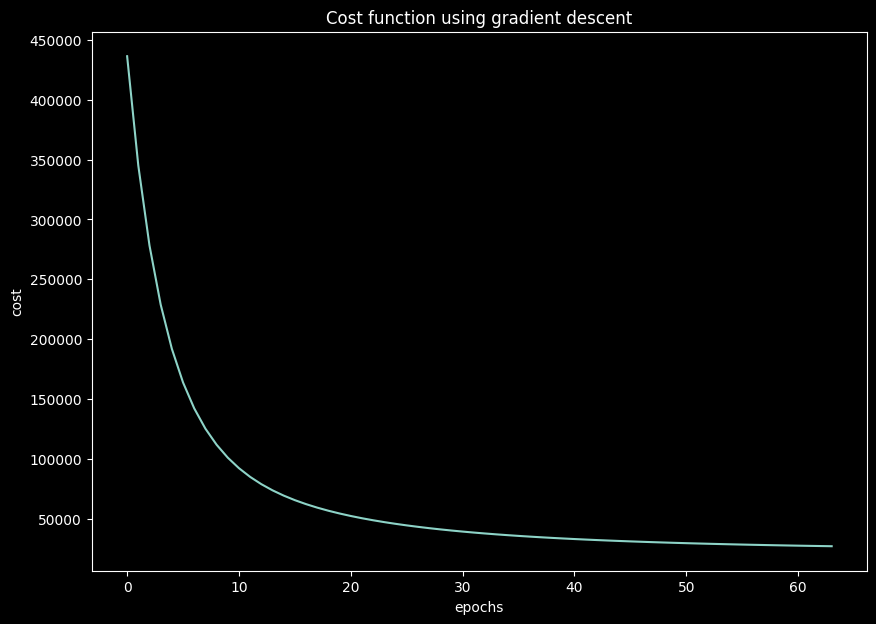

In [ ]:
# Plot the costs for each epoch
fig = plt.figure(figsize=(10, 7))
plt.plot(costs)
plt.xlabel("epochs")
plt.ylabel("cost")
plt.title("Cost function using gradient descent")
plt.show()

# 3. Exercise: Introducing regularization

Let us introduce a regularization penalty term in the cost function. The new cost function is defined as follows:


\begin{equation*}
\tilde{J} = \sum\limits_{i=1}^V \sum\limits_{j=1}^V f(X_{ij}) (\log X_{ij} - W_i^T \tilde{W}_j - b_i - \tilde{b}_j)^2 + \lambda \left( ||W||_{\text{F}}^2 +   ||\tilde{W}||_{\text{F}}^2 + ||b||_2^2 + ||\tilde{b} ||_2^2 \right) 
\end{equation*}




---
<font color=green>Q15:</font>
<br><font color='green'>
Show that: 
\begin{equation}
||W||_{\text{F}}^2 = \sum\limits_{i=1}^V W_i^T W_i
\end{equation}

</font>

---

---
**Solution:**

Let $W = [w_{ij}]_{ij}$. 

For all $v \in \{1, \dots, V \} \quad W_v = [w_{v1}, \dots, w_{vD}]^T \in \mathcal{M}_{D, 1}(\mathbb{R})$. 

Therefore:

\begin{align}
||W||_{\text{F}}^2 &= \sum\limits_{v=1}^{V} \left( \sum\limits_{d=1}^{D} |w_{vd}|^2 \right) \\
&=  \sum\limits_{v=1}^{V} W_v^T W_v
\end{align}

---

---
<font color=green>Q16:</font>
<br><font color='green'>
Deduce that for all $i \in \{1, \dots, V \}$:
\begin{align} 
& \nabla_{W_i} (||W||_{\text{F}}^2) = 2W_i \quad \text{(3.1)} \\ 
&(\text{Hint}: \forall z \in \mathbb{R}^D \ \forall A \in \mathcal{M}_{D, D}(\mathbb{R}) \quad \nabla_z (z^T A z) = (A + A^T)z )
\end{align} 

</font>

---

---
**Solution:**

For all $i \in \{1, \dots, V \}$:


\begin{align} 
 \nabla_{W_i} (||W||_{\text{F}}^2) &= \nabla_{W_i} \left( \sum\limits_{v=1}^{V} W_v^T W_v \right) \\
 &=  \sum\limits_{v=1}^{V} \nabla_{W_i} \left( W_v^T W_v \right) \\
 &=  \nabla_{W_i} \left( W_i^T I_D W_i \right) \\
 &=  (I_D + I_D^T)W_i \\
 &= 2 W_i
\end{align} 

---

---
<font color=green>Q17:</font>
<br><font color='green'>
From the equations(2.1), (2.2), (2.3), (2.4) and (3.1), show that the update equations for the method of alternating least squares become: 

\begin{align*}
&W_i^{(t+1)} \longleftarrow \left( \sum_{j'=1}^V f(X_{ij'}) \tilde{W}_{j'}^{(t)} \tilde{W}_{j'}^{(t)^T} + \lambda I_D \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - b_i^{(t)} - \tilde{b}_{j'}^{(t)}) \tilde{W}_{j'}^{(t)} \right)  \\
&\tilde{W}_j^{(t+1)} \longleftarrow \left( \sum_{i'=1}^V f(X_{i' j}) W_{i'}^{(t)} W_{i'}^{(t)^T} + \lambda I_D \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - b_{i'}^{(t)} - \tilde{b}_{j}^{(t)}) W_{i'}^{(t)} \right) \\
&b_i^{(t+1)} \longleftarrow \left( \sum_{j'=1}^V f(X_{ij'}) + \lambda  \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - W_i^{(t)^T} \tilde{W}_{j'}^{(t)} - \tilde{b}_{j'}^{(t)}) \right)  \\
&\tilde{b}_j^{(t+1)} \longleftarrow \left( \sum_{i'=1}^V f(X_{i' j}) + \lambda  \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - W_{i'}^{(t)^T} \tilde{W}_{j}^{(t)} - b_{i'}^{(t)}) \right) 
\end{align*}
</font>

---

---
**Solution:**


Let us compute the gradients of the cost function $\tilde{J}$ with respect to all the parameters:


For all $i \in \{1, \dots, V \}$ and all $j \in \{ 1, \dots, V \}$:


\begin{align} 
& \nabla_{W_i} \tilde{J}(W_i) = -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} + 2 \lambda W_i \quad \text{(From (2.1) and Question 18)} \\
& \nabla_{\tilde{W}_j} \tilde{J}(W_j) = -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) W_{i'} + 2 \lambda \tilde{W}_j \quad \text{(From (2.2) and Question 18)}  \\
&\nabla_{b_i} \tilde{J}(b_i) = -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) + 2 \lambda b_i \quad \text{(From (2.3)} \\
& \nabla_{\tilde{b}_j} \tilde{J}(\tilde{b}_j) = -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) + 2 \lambda \tilde{b}_j \quad \text{(From (2.4)} 
\end{align}

Let us deduce the update equations:

* For $W_i$:
\begin{align*}
\nabla_{W_i} J(W_i) = 0 & \iff -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} + 2 \lambda W_i = 0  \\
& \iff \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} = \sum_{j'=1}^V f(X_{ij'})  W_i^T \tilde{W}_{j'} \tilde{W}_{j'} + \lambda W_i \\
& \iff \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} = \left( \sum_{j'=1}^V f(X_{ij'})  \tilde{W}_{j'}^T \tilde{W}_{j'} + \lambda I_D \right) W_i   \\
& \iff W_i = \left( \sum_{j'=1}^V f(X_{ij'}) \tilde{W}_{j'} \tilde{W}_{j'}^T + \lambda I_D \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - b_i - \tilde{b}_{j'}) \tilde{W}_{j'} \right) 
\end{align*}

* For $\tilde{W}_{j}$:

\begin{align*}
\nabla_{\tilde{W}_j} J(\tilde{W}_j) = 0 & \iff  -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) + 2 \lambda \tilde{W}_j = 0   \\
&\iff \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - b_{i'} - \tilde{b}_j \right) W_{i'} = \sum_{i'=1}^V f(X_{i' j})  W_{i'}^T \tilde{W}_j  W_{i'} + \lambda \tilde{W}_j \\
& \iff \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - b_{i'} - \tilde{b}_j \right) W_{i'} = \left( \sum_{i'=1}^V f(X_{i' j})  W_{i'} W_{i'}^T + \lambda I_D \right)  \tilde{W}_j    \\
& \iff\tilde{W}_j = \left( \sum_{i'=1}^V f(X_{i' j}) W_{i'} W_{i'}^T + \lambda I_D \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - b_{i'} - \tilde{b}_{j}) W_{i'} \right)
\end{align*}

* For $b_i$:
\begin{align*}
\nabla_{b_i} J(b_i) = 0  & \iff -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) + 2 \lambda b_i = 0 \\
& \iff \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - \tilde{b}_{j'} \right)  = \left( \sum_{j'=1}^V f(X_{ij'}) + \lambda \right) b_i \\
& \iff b_i = \left( \sum_{j'=1}^V f(X_{ij'}) + \lambda \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - W_i^T \tilde{W}_{j'} - \tilde{b}_{j'}) \right)
\end{align*}

* For $\tilde{b}_j$:
\begin{align*}
\nabla_{\tilde{b}_j} J(\tilde{b}_j) = 0  & \iff -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) + 2 \lambda \tilde{b}_j  = 0  \\
& \iff \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} -  \right) = \left(\sum_{i'=1}^V f(X_{i' j}) + \lambda \right) \tilde{b}_j \\
& \iff \tilde{b}_j = \left( \sum_{i'=1}^V f(X_{i' j}) + \lambda \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - W_{i'}^T \tilde{W}_{j} - b_{i'}) \right) 
\end{align*}

We deduce the following update equations: 

\begin{align*}
&W_i^{(t+1)} \longleftarrow \left( \sum_{j'=1}^V f(X_{ij'}) \tilde{W}_{j'}^{(t)} \tilde{W}_{j'}^{(t)^T} + \lambda I_D \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - b_i^{(t)} - \tilde{b}_{j'}^{(t)}) \tilde{W}_{j'}^{(t)} \right)  \\
&\tilde{W}_j^{(t+1)} \longleftarrow \left( \sum_{i'=1}^V f(X_{i' j}) W_{i'}^{(t)} W_{i'}^{(t)^T} + \lambda I_D \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - b_{i'}^{(t)} - \tilde{b}_{j}^{(t)}) W_{i'}^{(t)} \right) \\
&b_i^{(t+1)} \longleftarrow \left( \sum_{j'=1}^V f(X_{ij'}) + \lambda  \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - W_i^{(t)^T} \tilde{W}_{j'}^{(t)} - \tilde{b}_{j'}^{(t)}) \right)  \\
&\tilde{b}_j^{(t+1)} \longleftarrow \left( \sum_{i'=1}^V f(X_{i' j}) + \lambda  \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - W_{i'}^{(t)^T} \tilde{W}_{j}^{(t)} - b_{i'}^{(t)}) \right) 
\end{align*}



---

---
<font color=green>Q18:</font>
<br><font color='green'>
 What would be the update equations for minimizing the new loss function $\tilde{J}$ by using the gradient descent algorithm.
</font>

---

---
**Solution:**

We will set a number of epochs $N_{\text{epochs}}$ and a learning rate $\eta$. 

* Initialize randomly $W^{(0)}, \tilde{W}^{(0)}, b^{(0)}, \tilde{b}^{(0)}$
* For $t \in \{0, \dots, N_{\text{epochs}}-2\}$:
  * For $i \in \{0, \dots, V-1 \}$:
  \begin{align}
  &W_i^{(t+1)} \longleftarrow W_i^{(t)} - \eta \nabla_{W_i} \tilde{J} (W_i^{(t)}) \\
  &\text{with} \quad \nabla_{W_i} \tilde{J} (W_i) = -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} + 2 \lambda W_i
  \end{align}

  * For $j \in \{0, \dots, V-1 \}$:
  \begin{align}
  &\tilde{W}_j^{(t+1)} \longleftarrow \tilde{W}_j^{(t)} - \eta \nabla_{\tilde{W}_j} \tilde{J} (\tilde{W}_j^{(t)}) \\
  &\text{with} \quad \nabla_{\tilde{W}_j} \tilde{J} (\tilde{W}_j) = -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) + 2 \lambda \tilde{W}_j 
  \end{align}

  * For $i \in \{0, \dots, V-1 \}$:
  \begin{align}
  &b_i^{(t+1)} \longleftarrow b_i^{(t)} - \eta \nabla_{b_i} \tilde{J} (b_i^{(t)}) \\
  &\text{with} \quad \nabla_{b_i} \tilde{J} (b_i) = -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) + 2 \lambda b_i
  \end{align}

  * For $j \in \{0, \dots, V-1 \}$:
  \begin{align}
  &\tilde{b}_j^{(t+1)} \longleftarrow \tilde{b}_j^{(t)} - \eta \nabla_{\tilde{b}_j} \tilde{J} (\tilde{b}_j^{(t)}) \\
  &\text{with} \quad \nabla_{\tilde{b}_j} \tilde{J} (\tilde{b}_j) = -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) + 2 \lambda \tilde{b}_j 
  \end{align}



---

# Appendix 

---
<br><font color='green'>
Let us show that:

\begin{align*}
&\nabla_{W_i} J(W_i) = 0 \iff W_i = \left( \sum_{j'=1}^V f(X_{ij'}) \tilde{W}_{j'} \tilde{W}_{j'}^T \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - b_i - \tilde{b}_{j'}) \tilde{W}_{j'} \right)  \\
&\nabla_{\tilde{W}_j} J(\tilde{W}_j) = 0 \iff \tilde{W}_j = \left( \sum_{i'=1}^V f(X_{i' j}) W_{i'} W_{i'}^T \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - b_{i'} - \tilde{b}_{j}) W_{i'} \right)  \\
&\nabla_{b_i} J(b_i) = 0 \iff b_i = \left( \sum_{j'=1}^V f(X_{ij'})  \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - W_i^T \tilde{W}_{j'} - \tilde{b}_{j'}) \right)  \\
&\nabla_{\tilde{b}_j} J(\tilde{b}_j) = 0 \iff \tilde{b}_j = \left( \sum_{i'=1}^V f(X_{i' j})  \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - W_{i'}^T \tilde{W}_{j} - b_{i'}) \right) 
\end{align*}
</font>

---

--- 
**Proof:**

First, we need to prove a preliminary result:

\begin{equation*}
  \forall a,b \in \mathcal{M}_{D, 1}(\mathbb{R}) \quad (a^T b) \ b = (b \ b^T) \ a \quad (\Delta)
\end{equation*}


Indeed, 

\begin{align}
\forall a,b \in \mathcal{M}_{D, 1}(\mathbb{R}) \quad (a^T b) \ b  &= b \ (a^T b) \\
&= b \ (b^T a) \quad (\text{As} \ a^Tb \ \text{is a scalar, it's equal to its transpose}) \\
&=  (b b^T) \ a 
\end{align}

For all $i \in \{1, \dots, V \}$ and for all $j \in \{1, \dots, V \}$. 

Let us find the optimal parameters by setting the gradients to 0:

* For $W_i$:
\begin{align*}
\nabla_{W_i} J(W_i) = 0 & \iff -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} = 0 \quad \text{(From (2.1))} \\
& \iff \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} = \sum_{j'=1}^V f(X_{ij'})  W_i^T \tilde{W}_{j'} \tilde{W}_{j'} \\
& \iff \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - b_i - \tilde{b}_{j'} \right) \tilde{W}_{j'} = \left( \sum_{j'=1}^V f(X_{ij'})  \tilde{W}_{j'} \tilde{W}_{j'}^T \right) W_i  \quad (\text{From} \ (\Delta)) \\
& \iff W_i = \left( \sum_{j'=1}^V f(X_{ij'}) \tilde{W}_{j'} \tilde{W}_{j'}^T \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - b_i - \tilde{b}_{j'}) \tilde{W}_{j'} \right) 
\end{align*}

* For $\tilde{W}_{j}$:

\begin{align*}
\nabla_{\tilde{W}_j} J(\tilde{W}_j) = 0 & \iff  -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) = 0  \quad \text{(From (2.2))} \\
&\iff \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - b_{i'} - \tilde{b}_j \right) W_{i'} = \sum_{i'=1}^V f(X_{i' j})  W_{i'}^T \tilde{W}_j  W_{i'} \\
& \iff \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - b_{i'} - \tilde{b}_j \right) W_{i'} = \left( \sum_{i'=1}^V f(X_{i' j})  W_{i'} W_{i'}^T \right)  \tilde{W}_j    \\
& \iff\tilde{W}_j = \left( \sum_{i'=1}^V f(X_{i' j}) W_{i'} W_{i'}^T \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - b_{i'} - \tilde{b}_{j}) W_{i'} \right)
\end{align*}

* For $b_i$:
\begin{align*}
\nabla_{b_i} J(b_i) = 0  & \iff -2 \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - b_i - \tilde{b}_{j'} \right) = 0 \quad \text{(From (2.3))} \\
& \iff \sum_{j'=1}^V f(X_{ij'}) \left( \log X_{ij'} - W_i^T \tilde{W}_{j'} - \tilde{b}_{j'} \right)  = \left( \sum_{j'=1}^V f(X_{ij'}) \right) b_i \\
& \iff b_i = \left( \sum_{j'=1}^V f(X_{ij'})  \right)^{-1} \left( \sum_{j'=1}^{V} f(X_{ij'})( \log X_{ij'} - W_i^T \tilde{W}_{j'} - \tilde{b}_{j'}) \right)
\end{align*}

* For $\tilde{b}_j$:
\begin{align*}
\nabla_{\tilde{b}_j} J(\tilde{b}_j) = 0  & \iff -2 \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'} - \tilde{b}_j \right) = 0 \quad \text{(From (2.4))} \\
& \iff \sum_{i'=1}^V f(X_{i' j}) \left( \log X_{i' j} - W_{i'}^T \tilde{W}_j - b_{i'}   \right) = \left(\sum_{i'=1}^V f(X_{i' j}) \right) \tilde{b}_j \\
& \iff \tilde{b}_j = \left( \sum_{i'=1}^V f(X_{i' j})  \right)^{-1} \left( \sum_{i'=1}^{V} f(X_{i' j})( \log X_{i' j} - W_{i'}^T \tilde{W}_{j} - b_{i'}) \right) 
\end{align*}

---

### Contact

If you have any question regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk

